# Monet Image Generation Kaggle Competition

For this project, we are using generative adversarial networks (GANS) to generate art that resembles a Monet painting. This is done by importing photos of monet paintings and trick a classifier into thinking this is a real Monet painting. 

In [1]:
# Load libraries

import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape
from tensorflow.keras.optimizers import Adam

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Number of replicas: 1


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Brief description of the problem and data 

A GAN consists of two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images and then the generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images. TPU is used for image training.

The goal of this trask is to build a GAN that generates 7,000 to 10,000 Monet-style images.



# Data description, shape and size

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos. TFRecord format is a simple format for storing a sequence of binary records

The monet directories will be used to train the model. The photo directories contain photos which we will add monet-style to and submit the generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

This submission was influenced heavily by this tutorial:
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

In [2]:
monet_files = tf.io.gfile.glob('/kaggle/input/monet-tfrec/*.tfrec')
print('Monet TFRecord Files:', len(monet_files))


photo_files = tf.io.gfile.glob('/kaggle/input/photo-tfrec/*.tfrec')
print('Photo TFRecord Files:', len(photo_files))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [3]:
monet_eda = "../input/gan-getting-started/monet_jpg"
photo_eda = "../input/gan-getting-started/photo_jpg"

In [4]:
# Retrieve image path from directory
def image_path(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [5]:
monet_eda1 = image_path(monet_eda)
photo_eda1 = image_path(photo_eda)

All the images for the competition are sized to 256x256. As these images are RGB images, set the channel to 3. 

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 




**Inspect:**
Upon inspecting the dataset it was found that there are 
Monet Images:  300
Photo Images:  7038

In [6]:
# number of images in monet and photo datasets
print("Monet Images: ", len(monet_eda1))
print("Photo Images: ", len(photo_eda1))

Monet Images:  300
Photo Images:  7038


# Clean
It is necessary to scale the images to [-1, 1]. Then the labels and image id will be dropped so that only the image from the TFRecord is returned in the generative model. f


In [7]:

image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [8]:
autotune = tf.data.experimental.AUTOTUNE
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset

In [10]:
monet_ds = load_dataset(monet_files, labeled=True).batch(1)
photo_ds = load_dataset(photo_files, labeled=True).batch(1)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

**Visualize:**

Here we show the input data with an example of an input image and an example of a monet painting

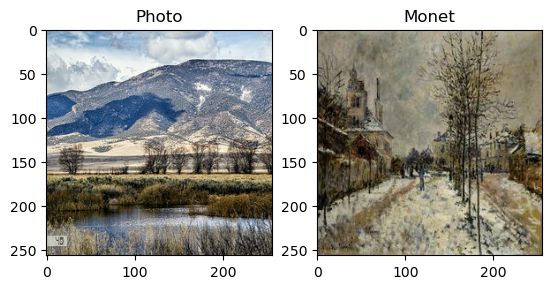

In [11]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)



In [12]:
# Define the function to parse TFRecords
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    
    return image

# Load TFRecords
monet_dataset = tf.data.TFRecordDataset(monet_files)
photo_dataset = tf.data.TFRecordDataset(photo_files)

# Parse and preprocess the datasets
autotune = tf.data.AUTOTUNE
monet_dataset = monet_dataset.map(parse_tfrecord_fn, num_parallel_calls=autotune)
photo_dataset = photo_dataset.map(parse_tfrecord_fn, num_parallel_calls=autotune)

# Convert images to tensors and apply normalization
def preprocess_image(image):
    image = tf.image.resize(image, (64, 64)) 
    image = tf.image.random_flip_left_right(image)  # Randomly flip images

    image = (image - 0.5) * 2.0  # Normalize to range [-1, 1]
    return image

monet_dataset = monet_dataset.map(preprocess_image, num_parallel_calls=autotune)
photo_dataset = photo_dataset.map(preprocess_image, num_parallel_calls=autotune)


The image was normalized and randomly flipped left to right, as an image augmentation techniques that avoids overfitting.

# Model Architecture 

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

GAN consists of two neural networks: a generator model and a discriminator model. Particulary, I would like to use CycleGAN to train this model. CycleGAN refers to Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks.CycleGAN uses a cycle consistency loss to enable training without the need for paired data

We'll be using a UNET architecture for our CycleGAN. The UNET architecture is able to localise and distinguish borders is by doing classification on every pixel, so the input and output share the same size.  This model also uses instance normalization instead of batch normalization.It has a symmetric U-shaped architecture is symmetric and consists a  contracting path and an explansive path, or downsampling and upsampling.The generator requires downsampling and upsampling. The downsample reduces the 2D dimensions, the width and height, of the image in a convolutional process.The upsample, or expansive path increases the dimensions of the of the image constituted by a transposed 2d convolutional layer. 

# The Generator

The generator downsamples the input image and then upsample while establishing skip connections, which help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers.



https://www.tensorflow.org/tutorials/generative/cyclegan

In [44]:
# Downsample function
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layers_list = [
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)
    ]
    
    if apply_instancenorm:
        layers_list.append(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    layers_list.append(layers.ELU())  # Use ELU activation

    result = keras.Sequential(layers_list)
    return result

# Upsample function

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layers_list = [
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)
    ]

    if apply_dropout:
        layers_list.append(layers.Dropout(0.3))
    
    layers_list.append(layers.ReLU())

    result = keras.Sequential(layers_list)
    return result

In [45]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Define the down and up stacks
    down_stack = [
        (64, 4, False), # (filters, size, apply_instancenorm)
        (128, 4, True),
        (256, 4, True),
        (512, 4, True),
        (512, 4, True),
        (512, 4, True),
        (512, 4, True),
        (512, 4, True)
    ]

    up_stack = [
        (512, 4, True), # (filters, size, apply_dropout)
        (512, 4, True),
        (512, 4, True),
        (512, 4, False),
        (256, 4, False),
        (128, 4, False),
        (64, 4, False)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs
    skips = []

    # Downsampling
    for filters, size, apply_instancenorm in down_stack:
        x = downsample(filters, size, apply_instancenorm)(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and skip connections
    for (filters, size, apply_dropout), skip in zip(up_stack, skips):
        x = upsample(filters, size, apply_dropout)(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


# The Discriminator
The discriminator classifies and image as real or generated based on input. The discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.

Generator G learns to transform image X to image Y. 

Generator F learns to transform image Y to image X. 

Discriminator D_X learns to differentiate between image X and generated image X (F(Y)).

Discriminator D_Y learns to differentiate between image Y and generated image Y (G(X)).


In [46]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inputs = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inputs

    down_stack = [
        (64, 4, False), # (filters, size, apply_instancenorm)
        (128, 4, True),
        (256, 4, True)
    ]

    # Downsampling
    for filters, size, apply_instancenorm in down_stack:
        x = downsample(filters, size, apply_instancenorm)(x)

    # Intermediate layers
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1,
                      kernel_initializer=initializer,
                      use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)

    # Output layer
    outputs = layers.Conv2D(1, 4, strides=1,
                            kernel_initializer=initializer)(x)

    return keras.Model(inputs=inputs, outputs=outputs)


In [47]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

# Building the CycleGAN model

During training the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss.

The training loop has 4 steps
* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimize

In [48]:
class CycleGan(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
        # Calculate gradients and apply them
        self.apply_gradients(tape, total_monet_gen_loss, total_photo_gen_loss,
                             monet_disc_loss, photo_disc_loss)

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

    def apply_gradients(self, tape, total_monet_gen_loss, total_photo_gen_loss,
                        monet_disc_loss, photo_disc_loss):
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))


# Loss functions

There is not paired data to train on in CycleGAN, so there is no confirmation that input x and target y are a meaningful pair in the training. To enforce that the network learns the correct mapping cycle consistency loss is used in which

Image X is passed via generator G that yields generated image Y^

Generator image Y^ is passed via generator F that yields cycled image X^

Mean absolute error is calculated between X and X^

    forward cycle consistency loss: X -> G(X) -> F(G(X)) ~X^
    backward cycle consistency loss: Y -> F(X) -> G(F(X)) ~Y^




In [49]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5


The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s so the generated image is compared to a matrix of 1s to find the loss.

In [50]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

The original photo and the twice transformed photo should be similar so cycle consistency loss is calculated by finding the average of their difference.

In [51]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with the image generator.  The identity loss compares the input with the output of the generator.



In [52]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN


Hyperparameter Tuning: 

In [53]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.1)
    photo_generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.1)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.7)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.7)

In [54]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [55]:
# Train the CycleGAN model using fit
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping 
early_stopping = EarlyStopping(
    monitor='val_loss',  # Choose a metric to monitor (e.g., validation loss)
    patience=5,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights to the best epoch
)
epochs=15
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=epochs,
    callbacks=[early_stopping]
)
# Monitoring epochs

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    for batch_data in tf.data.Dataset.zip((monet_ds, photo_ds)):
        # Perform a single training step
        results = cycle_gan_model.train_step(batch_data)
        

Epoch 1/15


2023-09-02 21:08:25.177842: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/sequential_80/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 134s 251ms/step - monet_gen_loss: 4.1429 - photo_gen_loss: 4.1553 - monet_disc_loss: 0.6667 - photo_disc_loss: 0.6810
Epoch 2/15
300/300 [==============================] - 75s 251ms/step - monet_gen_loss: 3.5012 - photo_gen_loss: 3.4869 - monet_disc_loss: 0.6362 - photo_disc_loss: 0.6542
Epoch 3/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 3.3481 - photo_gen_loss: 3.3183 - monet_disc_loss: 0.6215 - photo_disc_loss: 0.6423
Epoch 4/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 3.2016 - photo_gen_loss: 3.1952 - monet_disc_loss: 0.6191 - photo_disc_loss: 0.6358
Epoch 5/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 3.0536 - photo_gen_loss: 3.0749 - monet_disc_loss: 0.6204 - photo_disc_loss: 0.6304
Epoch 6/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.9207 - photo_gen_loss: 2.9561 - monet_disc_loss: 0.6191 - photo_di

# Results & Analysis: Hyper Parameter Tuning

A good model should have a low generator loss and high discriminator loss. Hyper parameters were tunes and the following results were output to find the best loss model. Output images were also analyzed to see which images looked the best by eye. The following hyper-parameters were tuned to find the best result: 

Learning Rate: The learning rate determines the step size taken during gradient descent optimization. Smaller and larger values were tested on this and the best was found to be: 

Beta: The beta parameter in the Adam optimizer controls the exponential decay rates of the averages for the first and second moments of the gradients. This affects how quickly or slowly it adapts the model. The best was found to be:

Epochs:The number of epochs determines how many times the model iterates over the entire dataset. Increasing epochs allows better convergence. When there was access to GPU, I used 15 epochs, but without access to GPU I used 4 epochs to speed up analysis. I also incorporated early stopping to prevent from overfitting. 

I also played with different preprocessing techniques such as jitter, rotation, and cropping

Batch Normalization: I also editted the batch normalization inside the discriminator and the generator code. This controls generalization. The following are outputs from the different models I ran and the changes I made to the model listed at the top of each run. To probe for the best model, I chose which had the highest discriminator loss, the lowest generator loss, and the best image output. 

**1.  with no randomjitter**

Epoch 1/14
300/300 [==============================] - 74s 247ms/step - monet_gen_loss: 2.8069 - photo_gen_loss: 3.1393 - monet_disc_loss: 0.5779 - photo_disc_loss: 0.4533
Epoch 2/14
300/300 [==============================] - 74s 247ms/step - monet_gen_loss: 2.8234 - photo_gen_loss: 3.1626 - monet_disc_loss: 0.5626 - photo_disc_loss: 0.4601
Epoch 3/14
300/300 [==============================] - 74s 247ms/step - monet_gen_loss: 2.8256 - photo_gen_loss: 3.1532 - monet_disc_loss: 0.5569 - photo_disc_loss: 0.4521
Epoch 4/14
300/300 [==============================] - 74s 247ms/step - monet_gen_loss: 2.8148 - photo_gen_loss: 3.1404 - monet_disc_loss: 0.5621 - photo_disc_loss: 0.4632
Epoch 5/14
300/300 [==============================] - 74s 246ms/step - monet_gen_loss: 2.8106 - photo_gen_loss: 3.1386 - monet_disc_loss: 0.5629 - photo_disc_loss: 0.4687
Epoch 6/14
300/300 [==============================] - 74s 247ms/step - monet_gen_loss: 2.8155 - photo_gen_loss: 3.1477 - monet_disc_loss: 0.5701 - photo_disc_loss: 0.4750
Epoch 7/14
300/300 [==============================] - 74s 246ms/step - monet_gen_loss: 2.8537 - photo_gen_loss: 3.1803 - monet_disc_loss: 0.5758 - photo_disc_loss: 0.4681
Epoch 8/14
300/300 [==============================] - 74s 247ms/step - monet_gen_loss: 3.3343 - photo_gen_loss: 3.4226 - monet_disc_loss: 0.4925 - photo_disc_loss: 0.4243
Epoch 10/14
300/300 [==============================] - 74s 246ms/step - monet_gen_loss: 3.1418 - photo_gen_loss: 3.3284 - monet_disc_loss: 0.5021 - photo_disc_loss: 0.4444
Epoch 11/14
300/300 [==============================] - 74s 246ms/step - monet_gen_loss: 2.9445 - photo_gen_loss: 3.3118 - monet_disc_loss: 0.5423 - photo_disc_loss: 0.4171
Epoch 12/14
300/300 [==============================] - 74s 246ms/step - monet_gen_loss: 2.9170 - photo_gen_loss: 3.2059 - monet_disc_loss: 0.5572 - photo_disc_loss: 0.4569
Epoch 13/14
300/300 [==============================] - 74s 247ms/step - monet_gen_loss: 2.8767 - photo_gen_loss: 3.1848 - monet_disc_loss: 0.5564 - photo_disc_loss: 0.4869
Epoch 14/14
300/300 [==============================] - 74s 246ms/step - monet_gen_loss: 2.8439 - photo_gen_loss: 3.1404 - monet_disc_loss: 0.5638 - photo_disc_loss: 0.4736


**2. With Jitter**

Epoch 1/14
300/300 [==============================] - 1672s 5s/step - monet_gen_loss: 4.9368 - photo_gen_loss: 5.0589 - monet_disc_loss: 0.6608 - photo_disc_loss: 0.6409
Epoch 2/14
300/300 [==============================] - 1590s 5s/step - monet_gen_loss: 3.7479 - photo_gen_loss: 3.8928 - monet_disc_loss: 0.6381 - photo_disc_loss: 0.5948
Epoch 3/14
300/300 [==============================] - 1576s 5s/step - monet_gen_loss: 3.6149 - photo_gen_loss: 3.6466 - monet_disc_loss: 0.6263 - photo_disc_loss: 0.6319
Epoch 4/14
300/300 [==============================] - 1567s 5s/step - monet_gen_loss: 3.4395 - photo_gen_loss: 3.4459 - monet_disc_loss: 0.6135 - photo_disc_loss: 0.6223
Epoch 5/14
300/300 [==============================] - 1574s 5s/step - monet_gen_loss: 3.2920 - photo_gen_loss: 3.2711 - monet_disc_loss: 0.6077 - photo_disc_loss: 0.6227
Epoch 6/14
300/300 [==============================] - 1569s 5s/step - monet_gen_loss: 3.2047 - photo_gen_loss: 3.1897 - monet_disc_loss: 0.6074 - photo_disc_loss: 0.6180
Epoch 7/14
300/300 [==============================] - 1572s 5s/step - monet_gen_loss: 3.1317 - photo_gen_loss: 3.1029 - monet_disc_loss: 0.6057 - photo_disc_loss: 0.6250
Epoch 8/14
300/300 [==============================] - 1599s 5s/step - monet_gen_loss: 3.0576 - photo_gen_loss: 3.0275 - monet_disc_loss: 0.6073 - photo_disc_loss: 0.6278
Epoch 9/14
300/300 [==============================] - 1608s 5s/step - monet_gen_loss: 2.9911 - photo_gen_loss: 2.9708 - monet_disc_loss: 0.6099 - photo_disc_loss: 0.6271
Epoch 10/14
300/300 [==============================] - 1595s 5s/step - monet_gen_loss: 2.9388 - photo_gen_loss: 2.9217 - monet_disc_loss: 0.6104 - photo_disc_loss: 0.6258
300/300 [==============================] - 1599s 5s/step - monet_gen_loss: 2.8949 - photo_gen_loss: 2.8845 - monet_disc_loss: 0.6124 - photo_disc_loss: 0.6252
Epoch 12/14
300/300 [==============================] - 1604s 5s/step - monet_gen_loss: 2.8556 - photo_gen_loss: 2.8485 - monet_disc_loss: 0.6149 - photo_disc_loss: 0.6238
Epoch 13/14
300/300 [==============================] - 1598s 5s/step - monet_gen_loss: 2.8226 - photo_gen_loss: 2.8231 - monet_disc_loss: 0.6169 - photo_disc_loss: 0.6216
Epoch 14/14
300/300 [==============================] - 1597s 5s/step - monet_gen_loss: 2.7805 - photo_gen_loss: 2.7852 - monet_disc_loss: 0.6194 - photo_disc_loss: 0.6231

**3.Learning rate changed to 1e-5 instead of 2e-5**

Epoch 1/14
300/300 [==============================] - 1655s 5s/step - monet_gen_loss: 5.7955 - photo_gen_loss: 5.8846 - monet_disc_loss: 0.6335 - photo_disc_loss: 0.6514
Epoch 2/14
300/300 [==============================] - 1589s 5s/step - monet_gen_loss: 3.9906 - photo_gen_loss: 3.9651 - monet_disc_loss: 0.6057 - photo_disc_loss: 0.6400
Epoch 3/14
300/300 [==============================] - 1596s 5s/step - monet_gen_loss: 3.9158 - photo_gen_loss: 3.8414 - monet_disc_loss: 0.5452 - photo_disc_loss: 0.5866
Epoch 4/14
300/300 [==============================] - 1603s 5s/step - monet_gen_loss: 3.8657 - photo_gen_loss: 3.8071 - monet_disc_loss: 0.5609 - photo_disc_loss: 0.5806
Epoch 5/14
300/300 [==============================] - 1599s 5s/step - monet_gen_loss: 3.7212 - photo_gen_loss: 3.6985 - monet_disc_loss: 0.5990 - photo_disc_loss: 0.5864
Epoch 6/14
300/300 [==============================] - 1591s 5s/step - monet_gen_loss: 3.6016 - photo_gen_loss: 3.5883 - monet_disc_loss: 0.6119 - photo_disc_loss: 0.6022
Epoch 7/14
300/300 [==============================] - 1601s 5s/step - monet_gen_loss: 3.4353 - photo_gen_loss: 3.4565 - monet_disc_loss: 0.6211 - photo_disc_loss: 0.6005
Epoch 8/14
300/300 [==============================] - 1600s 5s/step - monet_gen_loss: 3.2735 - photo_gen_loss: 3.3344 - monet_disc_loss: 0.6256 - photo_disc_loss: 0.5956
Epoch 9/14
300/300 [==============================] - 1591s 5s/step - monet_gen_loss: 3.1712 - photo_gen_loss: 3.2547 - monet_disc_loss: 0.6269 - photo_disc_loss: 0.5966
Epoch 10/14
300/300 [==============================] - 1605s 5s/step - monet_gen_loss: 3.0827 - photo_gen_loss: 3.1744 - monet_disc_loss: 0.6259 - photo_disc_loss: 0.6037
Epoch 11/14
229/300 [=====================>........] - ETA: 6:18 - monet_gen_loss: 3.0051 - photo_gen_loss: 3.1008 - monet_disc_loss: 0.6265 - photo_disc_loss: 0.6093

**4. beta 0.5 to 0.7** 

Epoch 1/14
300/300 [==============================] - 1547s 5s/step - monet_gen_loss: 5.8900 - photo_gen_loss: 6.0323 - monet_disc_loss: 0.6481 - photo_disc_loss: 0.6402
Epoch 2/14
300/300 [==============================] - 1475s 5s/step - monet_gen_loss: 3.9610 - photo_gen_loss: 4.0836 - monet_disc_loss: 0.6191 - photo_disc_loss: 0.5674
Epoch 3/14
300/300 [==============================] - 1474s 5s/step - monet_gen_loss: 3.9124 - photo_gen_loss: 3.9725 - monet_disc_loss: 0.5547 - photo_disc_loss: 0.5558
Epoch 4/14
300/300 [==============================] - 1469s 5s/step - monet_gen_loss: 3.8383 - photo_gen_loss: 3.8323 - monet_disc_loss: 0.5580 - photo_disc_loss: 0.5804
Epoch 5/14
300/300 [==============================] - 1477s 5s/step - monet_gen_loss: 3.6937 - photo_gen_loss: 3.6687 - monet_disc_loss: 0.5970 - photo_disc_loss: 0.6088
Epoch 6/14
300/300 [==============================] - 1471s 5s/step - monet_gen_loss: 3.5778 - photo_gen_loss: 3.5598 - monet_disc_loss: 0.6052 - photo_disc_loss: 0.6033
Epoch 7/14
300/300 [==============================] - 1466s 5s/step - monet_gen_loss: 3.4759 - photo_gen_loss: 3.4600 - monet_disc_loss: 0.6018 - photo_disc_loss: 0.6068
Epoch 8/14
300/300 [==============================] - 1466s 5s/step - monet_gen_loss: 3.3446 - photo_gen_loss: 3.3467 - monet_disc_loss: 0.6100 - photo_disc_loss: 0.6041
Epoch 9/14
300/300 [==============================] - 1461s 5s/step - monet_gen_loss: 3.2171 - photo_gen_loss: 3.2407 - monet_disc_loss: 0.6229 - photo_disc_loss: 0.6128
Epoch 10/14
300/300 [==============================] - 1458s 5s/step - monet_gen_loss: 3.1528 - photo_gen_loss: 3.1880 - monet_disc_loss: 0.6235 - photo_disc_loss: 0.6137
Epoch 11/14
300/300 [==============================] - 1464s 5s/step - monet_gen_loss: 3.0938 - photo_gen_loss: 3.1418 - monet_disc_loss: 0.6246 - photo_disc_loss: 0.6142
Epoch 12/14
300/300 [==============================] - 1464s 5s/step - monet_gen_loss: 3.0575 - photo_gen_loss: 3.1070 - monet_disc_loss: 0.6234 - photo_disc_loss: 0.6151
Epoch 13/14
300/300 [==============================] - 1453s 5s/step - monet_gen_loss: 3.0213 - photo_gen_loss: 3.0729 - monet_disc_loss: 0.6229 - photo_disc_loss: 0.6145
Epoch 14/14
300/300 [==============================] - 1463s 5s/step - monet_gen_loss: 2.9866 - photo_gen_loss: 3.0404 - monet_disc_loss: 0.6240 - photo_disc_loss: 0.6145

**5. beta to 0.25, though discriminator was 0.7 train on 4 epochs to speed up testing time. 3e-4 learning rate. 1e and 2e were comparable, but 2e performed slightly better**

Epoch 1/4
300/300 [==============================] - 1541s 5s/step - monet_gen_loss: 3.0990 - photo_gen_loss: 3.1557 - monet_disc_loss: 0.6418 - photo_disc_loss: 0.6374
Epoch 2/4
300/300 [==============================] - 1464s 5s/step - monet_gen_loss: 3.0318 - photo_gen_loss: 3.0600 - monet_disc_loss: 0.6263 - photo_disc_loss: 0.6288
Epoch 3/4
300/300 [==============================] - 1438s 5s/step - monet_gen_loss: 2.9686 - photo_gen_loss: 2.9909 - monet_disc_loss: 0.6258 - photo_disc_loss: 0.6281
Epoch 4/4
300/300 [==============================] - 1443s 5s/step - monet_gen_loss: 2.9318 - photo_gen_loss: 2.9536 - monet_disc_loss: 0.6216 - photo_disc_loss: 0.6268

**6. 1e-3, beta_1=0.2, 4 epochs**

Epoch 1/4
300/300 [==============================] - 1720s 6s/step - monet_gen_loss: 4.1054 - photo_gen_loss: 4.1440 - monet_disc_loss: 0.6717 - photo_disc_loss: 0.6795
Epoch 2/4
300/300 [==============================] - 1653s 6s/step - monet_gen_loss: 3.4129 - photo_gen_loss: 3.4176 - monet_disc_loss: 0.6389 - photo_disc_loss: 0.6536
Epoch 3/4
300/300 [==============================] - 1654s 6s/step - monet_gen_loss: 3.2553 - photo_gen_loss: 3.2728 - monet_disc_loss: 0.6280 - photo_disc_loss: 0.6392
Epoch 4/4
300/300 [==============================] - 1646s 5s/step - monet_gen_loss: 3.1275 - photo_gen_loss: 3.1638 - monet_disc_loss: 0.6253 - photo_disc_loss: 0.6334

**7. 1e-4, beta_1=0.2**

Epoch 1/4
300/300 [==============================] - 1713s 5s/step - monet_gen_loss: 2.6912 - photo_gen_loss: 2.7309 - monet_disc_loss: 0.5959 - photo_disc_loss: 0.6064
Epoch 2/4
300/300 [==============================] - 1630s 5s/step - monet_gen_loss: 2.6826 - photo_gen_loss: 2.7238 - monet_disc_loss: 0.6114 - photo_disc_loss: 0.6150
Epoch 3/4
300/300 [==============================] - 1636s 5s/step - monet_gen_loss: 2.6521 - photo_gen_loss: 2.6858 - monet_disc_loss: 0.6121 - photo_disc_loss: 0.6197
Epoch 4/4
300/300 [==============================] - 1639s 5s/step - monet_gen_loss: 2.6217 - photo_gen_loss: 2.6553 - monet_disc_loss: 0.6132 - photo_disc_loss: 0.6198

**8. 1e-3, beta_1=0.1**

Epoch 1/4
300/300 [==============================] - 1565s 5s/step - monet_gen_loss: 4.1263 - photo_gen_loss: 4.1867 - monet_disc_loss: 0.6775 - photo_disc_loss: 0.6806
Epoch 2/4
300/300 [==============================] - 1506s 5s/step - monet_gen_loss: 3.4555 - photo_gen_loss: 3.4832 - monet_disc_loss: 0.6450 - photo_disc_loss: 0.6538
Epoch 3/4
300/300 [==============================] - 1493s 5s/step - monet_gen_loss: 3.3175 - photo_gen_loss: 3.3434 - monet_disc_loss: 0.6319 - photo_disc_loss: 0.6404
Epoch 4/4
300/300 [==============================] - 1491s 5s/step - monet_gen_loss: 3.2067 - photo_gen_loss: 3.2284 - monet_disc_loss: 0.6246 - photo_disc_loss: 0.6380

**9. change dropout 0.3 to 0.5, 1e-3, beta_1=0.1, discriminator 0.7**

Epoch 1/15
2023-09-02 18:42:13.341810: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
300/300 [==============================] - 133s 252ms/step - monet_gen_loss: 2.4352 - photo_gen_loss: 2.6347 - monet_disc_loss: 0.6496 - photo_disc_loss: 0.6138
Epoch 2/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.4727 - photo_gen_loss: 2.6371 - monet_disc_loss: 0.6399 - photo_disc_loss: 0.6110
Epoch 3/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.3984 - photo_gen_loss: 2.5512 - monet_disc_loss: 0.6474 - photo_disc_loss: 0.6229
Epoch 4/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.7223 - photo_gen_loss: 2.6911 - monet_disc_loss: 0.6089 - photo_disc_loss: 0.6228
Epoch 5/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.5627 - photo_gen_loss: 2.6100 - monet_disc_loss: 0.6337 - photo_disc_loss: 0.6201
Epoch 6/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.4782 - photo_gen_loss: 2.5492 - monet_disc_loss: 0.6382 - photo_disc_loss: 0.6329
Epoch 7/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.4413 - photo_gen_loss: 2.4974 - monet_disc_loss: 0.6380 - photo_disc_loss: 0.6409
Epoch 8/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.4439 - photo_gen_loss: 2.5035 - monet_disc_loss: 0.6432 - photo_disc_loss: 0.6375
Epoch 9/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.6952 - photo_gen_loss: 2.5633 - monet_disc_loss: 0.5973 - photo_disc_loss: 0.6391
Epoch 10/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.5948 - photo_gen_loss: 2.6066 - monet_disc_loss: 0.6446 - photo_disc_loss: 0.6298
Epoch 11/15
300/300 [==============================] - 76s 253ms/step - monet_gen_loss: 2.5740 - photo_gen_loss: 2.5382 - monet_disc_loss: 0.6226 - photo_disc_loss: 0.6369
Epoch 12/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.4751 - photo_gen_loss: 2.4960 - monet_disc_loss: 0.6346 - photo_disc_loss: 0.6374
Epoch 13/15
300/300 [==============================] - 76s 253ms/step - monet_gen_loss: 2.5184 - photo_gen_loss: 2.5513 - monet_disc_loss: 0.6431 - photo_disc_loss: 0.6306
Epoch 14/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.4661 - photo_gen_loss: 2.5184 - monet_disc_loss: 0.6500 - photo_disc_loss: 0.6341
Epoch 15/15
300/300 [==============================] - 76s 252ms/step - monet_gen_loss: 2.4492 - photo_gen_loss: 2.4997 - monet_disc_loss: 0.6428 - photo_disc_loss: 0.6361

# Visualizing 

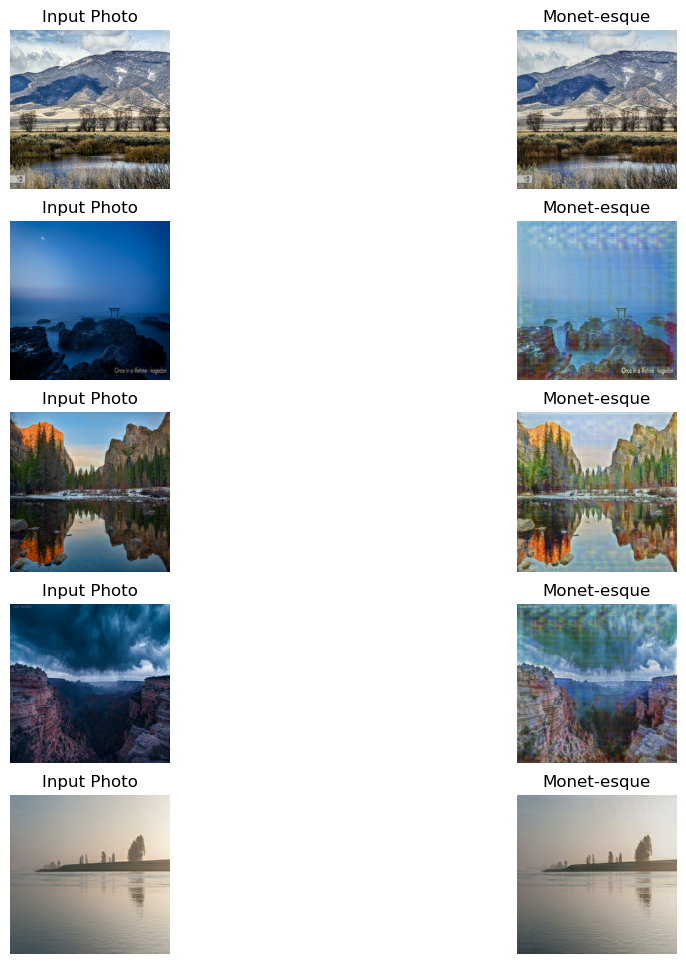

In [56]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Conclusion


The generator loss is reported as (monet_gen_loss, photo_gen_loss) and discriminator is reported as (monet_disc_loss, photo_disc_loss). A low generator loss suggests that the generator is minimizing the difference between real and generated images. The discriminator loss indicates how well the discriminators can differentiate between real and fake images. A high discriminator loss means that the generators are producing images which effectively fool the discriminators. The quality of the images were also monitored and saved for each output. to see that they represent the target Monet style.


The best hyper-parameters for generating Monet images were:

# Submission File

Generate 7,000-10,000 Monet-style images in jpg format which are 256x256x3 (RGB). Zip those images and your output from your Kernel to ONE outpule file images.zip.

Please note that Kaggle Kernels has a number of output files capped at 500. We highly encourage you to either directly write to a zip file as you generate images, or create a folder at ../tmp as your temporary directory.

In [57]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")